# Extended Python Example

Monitoring whether clusters still make sense over time is critical in production. Since customer behavior and data distributions may evolve, you want to keep an eye on key metrics and signals that indicate “cluster drift” or degradation in cluster quality. Below are some common approaches and an extended Python example that builds on our previous RFM segmentation code.

---

## Approaches for Monitoring Cluster Validity

1. **Track Internal Cluster Quality Metrics**  
   - **Inertia (Within-Cluster Sum of Squares):**  
     Monitor how “tight” clusters are. An increase in inertia on new data (relative to your baseline) may signal that new customer data don’t fit well with existing clusters.
   - **Silhouette Score:**  
     Measures how well-separated the clusters are. A drop in the silhouette score might indicate that clusters are overlapping more in the new data.
   - **Cluster Size Distribution:**  
     Compare the distribution (percentage of customers per cluster) between the baseline and new data. Significant changes may imply that customer segments are shifting.

2. **Drift Detection on Input Features**  
   - **Statistical Tests (e.g., Kolmogorov–Smirnov Test):**  
     Use tests to check whether the distributions of features (Recency, Frequency, Monetary) have shifted significantly over time.
   - **Population Stability Index (PSI):**  
     Compute PSI scores on each feature or on the cluster assignment distributions to quantify drift.

3. **Business Metrics and Domain Knowledge**  
   - **Domain-Specific KPIs:**  
     Monitor key business metrics (e.g., customer churn, average order value) associated with each cluster. If these metrics change significantly for a given cluster, it may be time to re-examine your clustering.
   - **Expert Review:**  
     Periodically review the clusters with domain experts. Sometimes the statistical metrics might change, but the clusters are still meaningful from a business perspective.

---

## Determining the Frequency for Re-training

- **Data Arrival Rate:**  
  If new data arrives daily but exhibits slow shifts, you might evaluate cluster metrics weekly or monthly.
- **Thresholds for Metric Changes:**  
  Define acceptable ranges for inertia, silhouette scores, or PSI. When these metrics deviate beyond your set thresholds, schedule a re-training.
- **Business Cycle Considerations:**  
  Some industries have seasonal behavior, so you might re-train after each season or quarter.
- **Automated Alerts:**  
  You can build monitoring systems that trigger alerts when metrics cross pre-defined thresholds.

---

## Extended Python Example

Below is an expanded version of our previous Python example. In this version, we simulate new incoming customer data and compute monitoring metrics to decide if the clusters are drifting. You can adjust thresholds based on your domain knowledge.


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Create Baseline Customer Data (Historical Data)
# -------------------------------
np.random.seed(42)  # For reproducible data generation

# Create a DataFrame with customer IDs and RFM values
baseline_data = pd.DataFrame({
    'CustomerID': np.arange(1, 101),
    'Recency': np.random.randint(1, 100, size=100),       # Days since last purchase
    'Frequency': np.random.randint(1, 20, size=100),        # Number of purchases
    'Monetary': np.random.randint(10, 1000, size=100)       # Amount spent
})

print("Baseline Customer Data:")
print(baseline_data.head())

# -------------------------------
# Step 2: Preprocess the Data (Standardization)
# -------------------------------
features = ['Recency', 'Frequency', 'Monetary']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(baseline_data[features])

# -------------------------------
# Step 3: Train k-means Clustering Model
# -------------------------------
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
baseline_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate baseline metrics
baseline_inertia = kmeans.inertia_
baseline_silhouette = silhouette_score(X_scaled, baseline_data['Cluster'])
baseline_distribution = baseline_data['Cluster'].value_counts(normalize=True).sort_index()

print("\nBaseline Cluster Assignments:")
print(baseline_data.head())
print("\nBaseline Inertia:", baseline_inertia)
print("Baseline Silhouette Score:", baseline_silhouette)
print("Baseline Cluster Distribution:")
print(baseline_distribution)

Baseline Customer Data:
   CustomerID  Recency  Frequency  Monetary
0           1       52         13       394
1           2       93          9       412
2           3       15         15       647
3           4       72         13       139
4           5       61          1        62

Baseline Cluster Assignments:
   CustomerID  Recency  Frequency  Monetary  Cluster
0           1       52         13       394        2
1           2       93          9       412        2
2           3       15         15       647        0
3           4       72         13       139        2
4           5       61          1        62        2

Baseline Inertia: 124.53387131643903
Baseline Silhouette Score: 0.29443418858174975
Baseline Cluster Distribution:
Cluster
0    0.28
1    0.22
2    0.30
3    0.20
Name: proportion, dtype: float64


In [2]:
# -------------------------------
# Step 4: Define a Function to Monitor Cluster Validity on New Data
# -------------------------------
def monitor_clusters(new_data, scaler, kmeans, baseline_data, baseline_inertia, baseline_silhouette, features, threshold=0.2):
    """
    Monitor cluster validity using inertia, silhouette score, cluster distribution,
    and feature drift (using the KS test).
    
    Parameters:
      new_data (DataFrame): New customer data with the same features.
      scaler: The scaler used on baseline data.
      kmeans: Trained kmeans model.
      baseline_data (DataFrame): Historical data.
      baseline_inertia (float): Inertia from the baseline model.
      baseline_silhouette (float): Silhouette score from the baseline model.
      features (list): List of feature column names.
      threshold (float): Relative change threshold to trigger a warning.
    """
    # Transform new data using the existing scaler
    X_new_scaled = scaler.transform(new_data[features])
    
    # Predict clusters for the new data
    new_clusters = kmeans.predict(X_new_scaled)
    new_data['Cluster'] = new_clusters
    
    # Compute inertia for new data
    # For each new data point, compute squared distance to its cluster center
    distances = (X_new_scaled - kmeans.cluster_centers_[new_clusters])**2
    new_inertia = np.sum(distances)
    
    # Compute silhouette score for new data
    # Note: Silhouette score requires at least 2 clusters and enough samples.
    new_silhouette = silhouette_score(X_new_scaled, new_clusters)
    
    # Compute new cluster distribution
    new_distribution = new_data['Cluster'].value_counts(normalize=True).sort_index()
    
    print("\n--- Monitoring Report ---")
    print("Baseline Inertia: {:.2f}".format(baseline_inertia))
    print("New Data Inertia: {:.2f}".format(new_inertia))
    print("Baseline Silhouette Score: {:.2f}".format(baseline_silhouette))
    print("New Data Silhouette Score: {:.2f}".format(new_silhouette))
    print("\nBaseline Cluster Distribution:")
    print(baseline_distribution)
    print("\nNew Data Cluster Distribution:")
    print(new_distribution)
    
    # Compare inertia and silhouette changes (relative difference)
    if abs(new_inertia - baseline_inertia) / baseline_inertia > threshold:
        print("Warning: Significant change in inertia detected. Consider re-training the model.")
    if abs(new_silhouette - baseline_silhouette) / baseline_silhouette > threshold:
        print("Warning: Significant change in silhouette score detected. Consider re-training the model.")
    
    # Feature drift detection using the Kolmogorov–Smirnov test
    for feature in features:
        stat, p_value = ks_2samp(baseline_data[feature], new_data[feature])
        print(f"\nKS Test for {feature}: statistic = {stat:.3f}, p-value = {p_value:.3f}")
        if p_value < 0.05:
            print(f"  -> {feature} distribution has changed significantly (p < 0.05).")
    
    # Return new_data with cluster assignments and computed metrics for further analysis if needed
    return new_data, new_inertia, new_silhouette, X_new_scaled

In [3]:
# -------------------------------
# Step 5: Simulate New Incoming Data and Monitor Clusters
# -------------------------------
# Simulate new customer data that might exhibit a drift in behavior
new_data = pd.DataFrame({
    'CustomerID': np.arange(101, 121),
    # For simulation, shift the distribution of Recency, Frequency, and Monetary slightly
    'Recency': np.random.randint(5, 120, size=20),       # Slightly different range
    'Frequency': np.random.randint(1, 25, size=20),        # Increased frequency range
    'Monetary': np.random.randint(20, 1200, size=20)       # Increased spending range
})

print("\nNew Incoming Customer Data (Before Clustering):")
print(new_data.head())


New Incoming Customer Data (Before Clustering):
   CustomerID  Recency  Frequency  Monetary
0         101       40          1        57
1         102       42          4       249
2         103      108          1       582
3         104       88         14       457
4         105      103         21        46


In [4]:
# Monitor the clusters with the new data
new_data, new_inertia, new_silhouette, X_new_scaled = monitor_clusters(
    new_data, scaler, kmeans, baseline_data, baseline_inertia, baseline_silhouette, features, threshold=0.2
)


--- Monitoring Report ---
Baseline Inertia: 124.53
New Data Inertia: 64.46
Baseline Silhouette Score: 0.29
New Data Silhouette Score: 0.16

Baseline Cluster Distribution:
Cluster
0    0.28
1    0.22
2    0.30
3    0.20
Name: proportion, dtype: float64

New Data Cluster Distribution:
Cluster
0    0.10
1    0.15
2    0.30
3    0.45
Name: proportion, dtype: float64

KS Test for Recency: statistic = 0.380, p-value = 0.013
  -> Recency distribution has changed significantly (p < 0.05).

KS Test for Frequency: statistic = 0.390, p-value = 0.010
  -> Frequency distribution has changed significantly (p < 0.05).

KS Test for Monetary: statistic = 0.170, p-value = 0.684


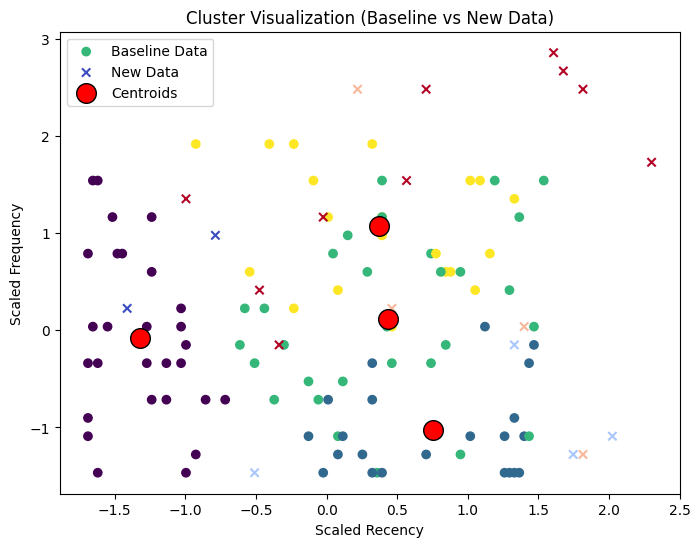

In [11]:
# -------------------------------
# Optional: Visualizing Cluster Centroids Over Time
# -------------------------------
# This can help to see if the centers are drifting (if you choose to update them periodically)
centroids = kmeans.cluster_centers_
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=baseline_data['Cluster'], cmap='viridis', marker='o', label='Baseline Data')
plt.scatter(X_new_scaled[:, 0], X_new_scaled[:, 1], c=new_data['Cluster'], cmap='coolwarm', marker='x', label='New Data')
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', label='Centroids', edgecolors='black')
plt.xlabel('Scaled Recency')
plt.ylabel('Scaled Frequency')
plt.title('Cluster Visualization (Baseline vs New Data)')
plt.legend()
plt.show()

## Explanation of the Extended Example

1. **Baseline Metrics:**  
   - We compute inertia and silhouette score on the baseline (historical) data after training our k-means model.  
   - We also calculate the cluster distribution (i.e., the percentage of customers in each cluster).

2. **Function `monitor_clusters`:**  
   - **Data Transformation & Cluster Assignment:** New data are standardized with the same scaler and assigned to clusters using the existing model.
   - **Metric Computation:**  
     - **Inertia:** Sum of squared distances for new data points is computed.
     - **Silhouette Score:** Provides an overall measure of clustering quality on new data.
     - **Cluster Distribution:** The relative frequency of cluster assignments in new data is compared with the baseline.
   - **Drift Detection:**  
     - The function uses the Kolmogorov–Smirnov (KS) test to detect shifts in the distributions of each feature.
     - If the relative change in inertia or silhouette score exceeds the threshold (20% in this example), a warning is printed.
   
3. **Simulating New Data:**  
   - New customer data are simulated with slightly shifted ranges to mimic potential drift in customer behavior.
   - The monitoring function is then used to compare these new data with the baseline.

4. **Visual Comparison:**  
   - A scatter plot is produced to visualize the distribution of baseline versus new data (in two dimensions) along with the cluster centroids.

---

## Determining When to Re-Train

- **Metric Thresholds:**  
  In the example, if the relative change in inertia or silhouette score is more than 20% (set by the `threshold` parameter), that triggers a warning. Adjust this threshold based on historical variability and business impact.

- **Regular Intervals:**  
  Even if metrics are within thresholds, it might be good to schedule a re-training (e.g., quarterly) if the business environment is known to evolve.

- **Data-Driven Alerts:**  
  Implement automated alerts in your production pipeline so that when metrics (or statistical tests) indicate significant drift, your system notifies you to consider re-training the model.

By systematically monitoring these metrics and incorporating automated checks, you ensure that your clustering model remains relevant and that your customer segmentation stays robust over time.